# This Notebook made by Amir Helmy shawky.
# (As a capstone project of Hands on Machine learning Book.)


<br>

# California Housing Prices
This dataset is based on data from 1990 California census.
## Looking at the Big Picture
The data pertains to the houses found in a given California district and some summary stats about them based on the 1990 census data.<br>The columns are as follows, their names are pretty self explanitory:

longitude

latitude

housingmedianage

total_rooms

total_bedrooms

population

households

median_income

median_house_value

ocean_proximity

This includes metrics for each block group in California.  
Block groups are the smallest geographical unit for which the US Census Bureau publishes sample data (a block group typically has a population of 600 to 3,000 people). 
We will just call them “districts” for short.
## Our Aim:
Is to bulid a model that should learn from this data and be able to predict the median housing price in any district, given by any other metrics. 

## The Objective in Business terms.
   - The model’s output (a prediction of a district’s median housing price) will be fed to another Machine Learning system along with many other signals.
   - This downstream system will determine whether it is worth investing in a given area or not. Getting this right is critical, as it directly affects revenue.

## The current solution before Using machine learning:
The district housing prices are currently estimated manually by experts, teams gathers up-to-date information about a district, and when they cannot get the median housing price, they estimate it using complex rules.<br>
This is costly and time-consuming, and their estimates are not great; in cases where they manage to find out the actual median housing price, they often realize that their estimates were off by more than 20%. <br>
This is why the company thinks that it would be useful to train a model to predict a district’s median housing price given other data about that district.<br>
The census data looks like a great dataset to exploit for this purpose, since it includes the median housing prices of thousands of districts, as well as other data.

## Frame of the problem
It is clearly a typical **supervised learning task** since we are given labeled training examples (each instance comes with the expected output, i.e., the district’s median housing price).<br>
Moreover, it is also a typical **regression task**, since we are asked to predict a value. More specifically, this is a multiple regression problem since the system will use multiple features to make a prediction.<br>
It is also a univariate regression problem since we are only trying to predict a single value for each district.


## Selecting Preformance Measure
A typical performance measure for regression problems is the Root Mean Square Error (RMSE). <br> 
It gives an idea of how much error the system typically makes in its predictions, with a higher weight for
large errors.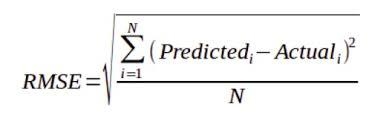

## Setup
First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures.

In [1]:
import sys
import sklearn
# Common imports
import numpy as np
import os

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


## Download the Data
Here is the function to fetch the data

In [4]:
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    """
    INPUTS:
        housing_url : the url of the data
        housing_path : path to download tha data
    Returns: 
        It creates a datasets/housing directory in our workspace,
        downloads the housing.tgz file,
        and extracts the housing.csv from it in this directory.
    """
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()



## Get the Data
**fetch_housing_data()**<br>
It creates a datasets/housing directory in our workspace, downloads the housing.tgz file, and extracts the housing.csv from it in this directory.

In [3]:
fetch_housing_data()

## Load the Data

In [7]:
import pandas as pd 

def load_housing_data(housing_path=HOUSING_PATH):
    """
    This Function retuens a pandas DataFrame object containing all the data.
    
    """
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [8]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


Each row represents one district, and each district has 10 attributes.

#### Getting a quick description of the data

In [9]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


**Observations**
 - The data have total (20640) of rows with (10) columns "attributes".
 - All the columns has no null-values except "total_bedrooms" has (207) missing value.
 - All atributes are numerical except "ocean_proximity" is a python object.
      - Since the data were in a csv file so this must mean it is a text attribute, so by looking at the head of the data it was repetitive which means it could be categorical feature, let us find out how many distinct values it has.

In [11]:
# Getting counts of distinct values on ocean_proximity column
housing.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

It is definitly a categorical feature, we will deal with it in the data cleaning section.

**let us look at the other Numerical fields with describe() function which shows its numerical summary**

In [12]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


let us plot a histogram of the data to get a better feel of the type of the data we are dealing with

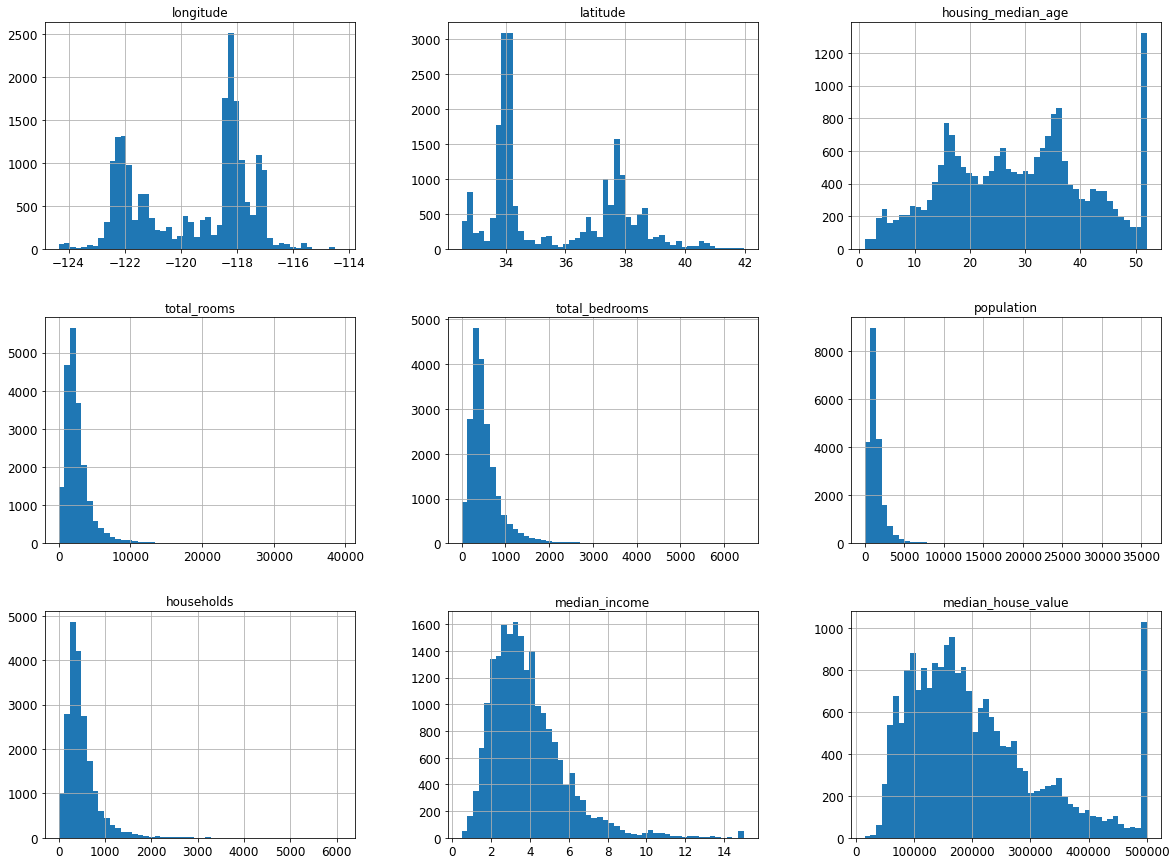

In [14]:
housing.hist(bins=50, figsize=(20,15))
plt.show();

**There are few things that i noticed from these histograms**
 1. The "median_income" column does not look like it is represents in US dollars, when i looked at the documentation of the data it says that the data is **scalled to the tens of thousands** (e.g. 3 means 30,000) and **capped** at 15 for higher meadian income and 0.5 for lower median income.
 2. The housing median age and the median house value were also capped 500000 for higher median house value.
 3. These attributes have very **different scales**.
 4. Finally, many histograms are **tail heavy**: they extend much farther to the right of the median than to the left. This may make it a bit harder for some Machine Learning algorithms to detect patterns. I will try transforming these attributes later on to have more bell-shaped distributions.


******

## Creating training & test sets
We cannot simply split our data with purely random sampling methods. This is generally fine if
our dataset is large enough, because this could run the risk of introducing a significant sampling bias.<br>
So I tried to maintain this ratio in the sample to guarantee that the test set is representative of the overall population with **stratified sampling**. <br>  Because if I used purely random sampling the survey results would be significantly biased.

So I first need to create an income category attribute. Let’s look at the median income histogram more closely





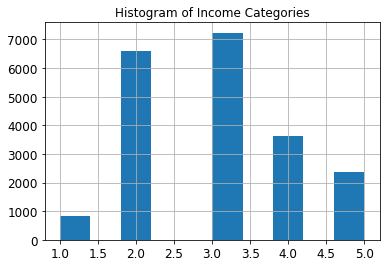

In [33]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

housing["income_cat"].hist();
plt.title("Histogram of Income Categories");

In [34]:
# percentages of each income category in the whole dataset
housing["income_cat"].value_counts() / len(h) *100

3    35.058140
2    31.884690
4    17.630814
5    11.443798
1     3.982558
Name: income_cat, dtype: float64

The data is mostly centered from cat2 to cat3 with the percentages showed above.
#### Now I will split the data taking into consideration stratified sampling to keep these ratios the same also in test set. 

In [40]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42, stratify=housing["income_cat"])


In [41]:
# Sanity check on th percentages
test_set["income_cat"].value_counts() / len(test_set)*100

3    35.053295
2    31.879845
4    17.635659
5    11.458333
1     3.972868
Name: income_cat, dtype: float64

The same ratios are the same in test set, so this way we spliteed the data with no bias for any category

In [63]:
# Deleting income_cat column as we dont need it anymore
for set_ in (housing, test_set, train_set):
    set_.drop("income_cat", axis=1, inplace= True)

*****

## Discover and Visualize the Data to Gain Insights
Since there is geographical information (latitude and longitude), it is a good idea to create a scatterplot of all districts to visualize the data.

In [43]:
# Taking a copy of train data to play with
housing = train_set.copy()

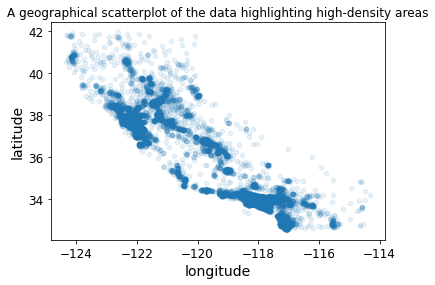

In [50]:
housing.plot(kind="scatter", y="latitude", x="longitude", alpha=0.1)
plt.title("A geographical scatterplot of the data highlighting high-density areas");

This looks like California all right with  highlight of the high-density districts.
<br>
Now let’s look at the housing prices on the plot.

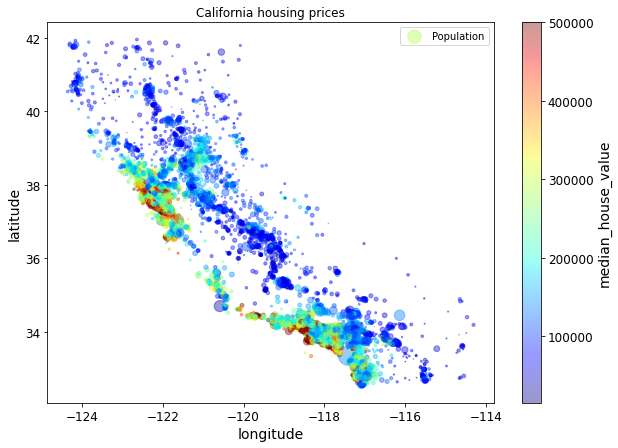

In [60]:
# Plotting housing prices with district population and the color to represent prices
housing.plot(kind="scatter", y="latitude", x="longitude", alpha=0.4,
            s=housing.population/100,            # the radius of each circle representsthe district’s population
            label="Population", figsize=(10,7),  # the color represents the price 
            c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True, sharex=False
            )
plt.legend()
plt.title("California housing prices");

### Observations
- The red color is expensive, Blue is cheep and the image tells us that the housing prices are very much related to the location (e.g., close to the ocean), but its not that simple as you may notice in the top left plot there are some districs close to ocean and it is cheep.
- Also prices is correlated to the population density as bigger circles represents larger population.

**************

## Looking for correlations 
There are a lot of ways to look for correlations in the data (**Calculating Pearson'r** ,**Plotting a heat-map  of the correaltions matrix**, **Plotting a scatter matrix in pandas**)<br>
Let us first look at pearson' r.

In [70]:
# Computing pearson'r between every pair of attributes
corr_matrix = housing.corr()

# Let us see how much each attributes correlates with median house value
corr_matrix.median_house_value.sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687160
total_rooms           0.135097
housing_median_age    0.114110
households            0.064506
total_bedrooms        0.047689
population           -0.026920
longitude            -0.047432
latitude             -0.142724
Name: median_house_value, dtype: float64

- The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation; for example, **the median house value tends to go up when the median income goes up**.<br> 
- When the coefficient is close to –1, it means that there is a strong negative correlation; you can see a small negative correlation between the latitude and the median house value (i.e., **prices have a slight tendency togo down when you go north**). 
- Finally, coefficients close to zero mean that there is no linear correlation

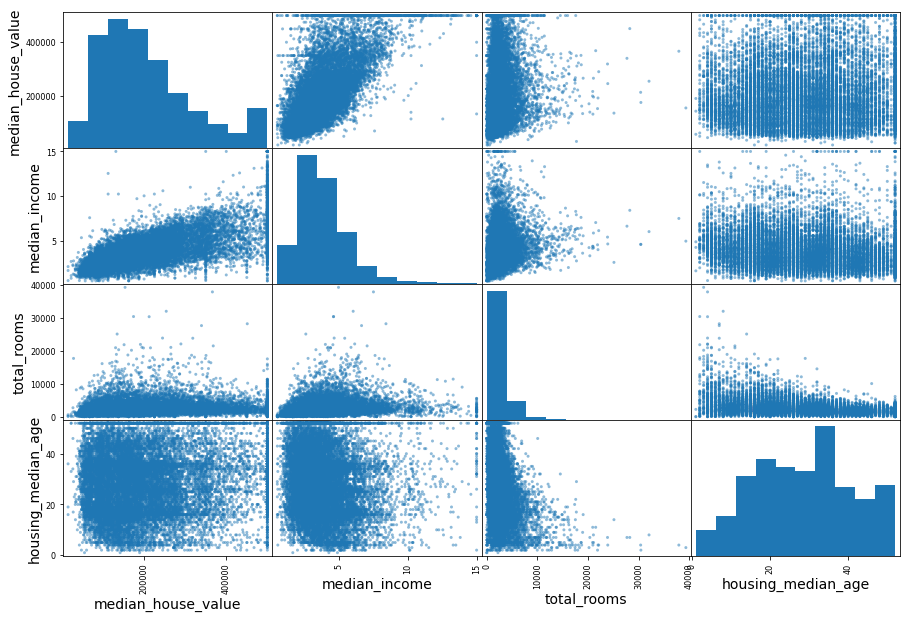

In [115]:
# Selecting some attributes because it would make 11*2= 121 plots
attributes = ["median_house_value", "median_income", "total_rooms","housing_median_age"]
# Plotting a Scatter matrix
pd.plotting.scatter_matrix(housing[attributes], figsize=(15, 10));